This notebook contains code for running basic time series analysis on the energy generated data, this time on a monthly scale

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime   # package that helps manipulate dates

#for decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose

# Exponential smoothing methods
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

# for time series cross validation
from sklearn.model_selection import TimeSeriesSplit

# used for autocorrelation and ARIMA/SARIMA
import statsmodels.api as sm

# for determining differencing in ARIMA models:
#statsmodels.tsa.stattools

# measuring MAE and RMSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# this controls warnings (which are sometimes annoying)
from warnings import catch_warnings
from warnings import filterwarnings

In [2]:
# turn warnings off when the code is working fine
filterwarnings("ignore")

# turn warnings back on when fucked
# warnings.filterwarnings("default")



In [3]:
# increase figure size
plt.rcParams['figure.figsize'] = [12, 8]

In [4]:
#Importing data and cleaning to make a nice df with 2 columns

# import data (already cleaned on github)
df = pd.read_csv("./energy_generated.csv")

#renaming the columns since old code was all lower case, want to reuse 
df.rename(columns={
        'Date': 'date', 
        'Energy_Generated': 'energy_generated'
    }, inplace=True)

# reads date as date
df['date'] = pd.to_datetime(df['date'],format = '%b-%y')  




In [5]:
# check for missing dates... seems there are none
print(pd.date_range(
  start="1999-01-01", end="2021-04-03", freq = 'MS').difference(df['date']))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


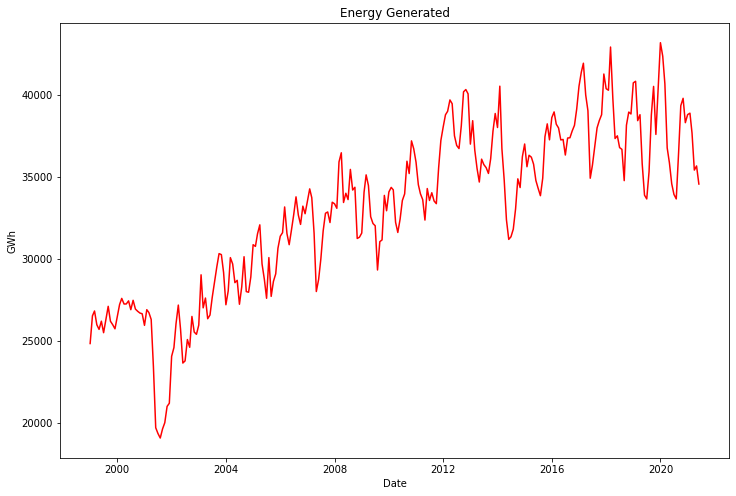

In [6]:
#plotting energy generated over full time period
plt.plot(df.date[:], df.energy_generated[:], 'r')   
plt.title('Energy Generated')
# Units not in GWh
plt.ylabel('GWh');
plt.xlabel('Date');
plt.show();

based on the graph above, something crazy was happening in 2001.  Quick DuckDuckGo search shows that there was a crazy drought at that time.  I'm gonna cut that out of the dataset.

In [7]:
df.iloc[30:40]

,date,energy_generated
30,2001-07-01,19362.00992
31,2001-08-01,19083.96026
32,2001-09-01,19641.53640
33,2001-10-01,20017.99485
34,2001-11-01,21013.09983
35,2001-12-01,21205.42183
36,2002-01-01,24068.67040
37,2002-02-01,24600.46229
38,2002-03-01,26055.44407
39,2002-04-01,27192.63981


In [8]:
df = df.iloc[36:]
df = df.reset_index(drop = True)

In [9]:
df.head()

,date,energy_generated
0,2002-01-01,24068.67040
1,2002-02-01,24600.46229
2,2002-03-01,26055.44407
3,2002-04-01,27192.63981
4,2002-05-01,25716.49754


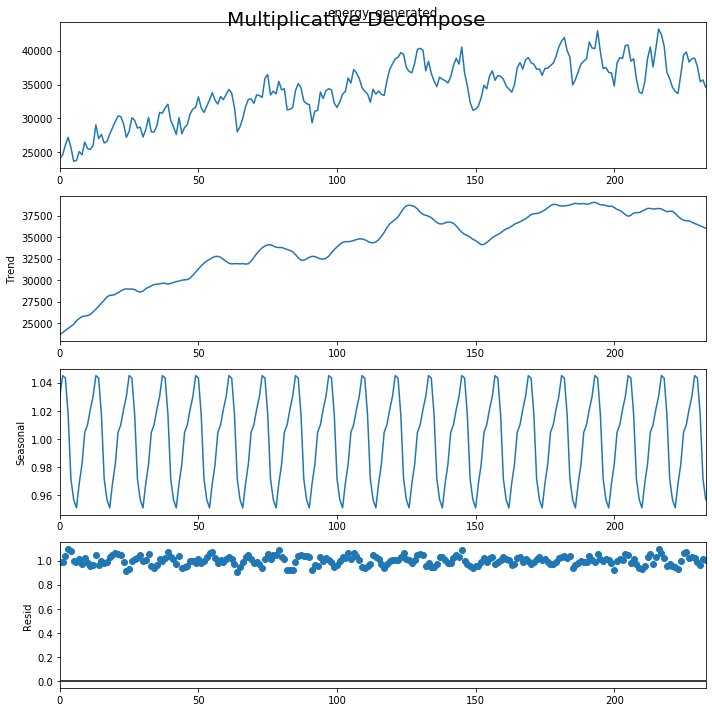

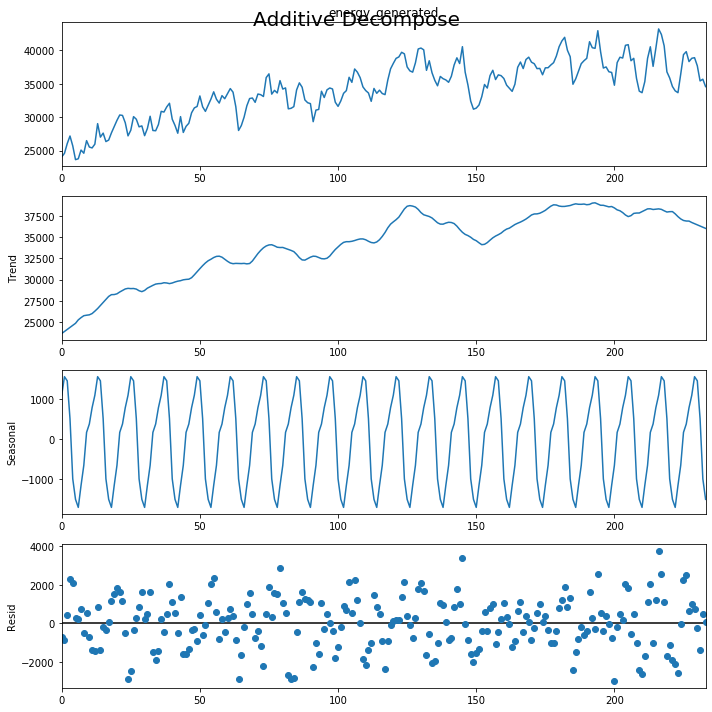

In [10]:
# Must choose a period for the decomposition; here choosing an annual one
per = 12

# Multiplicative Decomposition:  Returns seasonal, trend, and resid attributes
result_mul = seasonal_decompose(df['energy_generated'], model='multiplicative', extrapolate_trend='freq', period=per)

# Additive Decomposition
result_add = seasonal_decompose(df['energy_generated'], model='additive', extrapolate_trend='freq', period=per)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20)
result_add.plot().suptitle('Additive Decompose', fontsize=20)
plt.savefig('foo.png')
plt.show()

Seasonal naive decomposition

In [11]:
# Function to do basic seasonal naive method

def seasonal_naive(time_data, pred_length):
    '''
    This function implements the seasonal naive method.  Is bad, not robust, should delete
    
    Returns 
        preds: an array of the predicted values
        pred_mae: Mean absolute error of the predictions
    
    Inputs:
        time_data: Pandas df
            all the relevant data, including that which we want to predict
        pred_length: integer
            number of days we would like to predict
    '''
    
    # New series excluding the days that we want to predict
    train = time_data[:-pred_length]
    # The actual data that we aim to reproduce
    test = time_data[-pred_length:]
    
    # select the predicted values
    preds = train[-12:(-12+ pred_length)]
    
    #compute MAE
    mae = mean_absolute_error(preds,test)
    
    return preds, mae

In [12]:
# checking results of seasonal naive method
print(seasonal_naive(df['energy_generated'],11)[1])
# comparing to mean
print(np.mean(df['energy_generated']))
# percentage-wise
print(seasonal_naive(df['energy_generated'],3)[1]/np.mean(df['energy_generated']))



1980.0442027272709
34177.13315188032
0.015187677611614969


In [13]:
# Naive forecast
# size of prediction window (maxes out at 11)
pred_length = 3

# train/test split
train = df.iloc[:-pred_length,:]
test = df.iloc[-pred_length:,:]

# select the seasonal naive predicted values
# preds = test.copy()
#preds['energy_generated'] = train.iloc[-12:(-12+ pred_length),1]
preds = train.iloc[-12:(-12+ pred_length),:]
# preds['date'] = test['date']

#compute MAE
mae = mean_absolute_error(preds['energy_generated'],test['energy_generated'])

print(mae)


519.0712799999965


Above cells show that even just a seasonal naive method works very well for this data... it might be trivial to predict energy generation.  Let's check it under cross-validation, though.

In [14]:
# naive forecasting with cross validation

# size of prediction window (maxes out at 11)
pred_length = 3
print('We are predicting %s months in advance' %pred_length)

# number of cross-validtion splits to do
cross_splits = 47
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # seasonal naive
    preds = y_train[-12:(-12+ pred_length)]
    # compute MAE for this split
    mae = mean_absolute_error(preds,y_test)
#     print('MAE of Holt linear is %s' %mae)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of Seasonal Naive is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))

We are predicting 3 months in advance
[2484.67194, 1238.6549866666694, 1157.4794866666696, 3695.7217100000003, 3718.967563333337, 740.6893433333292, 1332.5329633333338, 834.0938833333324, 1329.8127366666668, 3807.6137466666696, 5465.528393333331, 3547.3592900000026, 4816.864850000003, 1253.930816666667, 3463.5832966666662, 1747.5224866666686, 2604.523126666669, 1067.666393333333, 2632.0131499999975, 3436.5474500000005, 2438.0456800000006, 2106.795306666667, 2792.742069999999, 2288.40582, 2497.8835000000013, 2282.9980066666685, 1921.5560166666644, 2670.2179733333346, 770.5453566666669, 2686.877543333331, 2053.6447666666645, 566.3037733333331, 1141.16393, 747.698963333336, 1498.5888500000026, 1492.9232499999998, 959.7039533333324, 1797.0324233333351, 2053.1297733333317, 2837.0948233333306, 1729.0647399999991, 2072.950913333334, 928.2657599999997, 1424.7685899999972, 1788.5331533333326, 3619.0120699999993, 519.0712799999965]
The CV MAE of Seasonal Naive is 2128.953104255319
That is 0.0622

Let's do some exponential smoothing models

In [15]:
# simple exponential smoothing

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Simple Exponential Smoothing
    # parameters chosen via optimization
    fit = SimpleExpSmoothing(y_train, initialization_method="estimated").fit(optimized = True)
    fcast = fit.forecast(pred_length).rename(r'$\alpha=%s$'%fit.model.params['smoothing_level'])
    # printing parameters and MAE
#     print('alpha is %s' %fit1.model.params['smoothing_level'])
#     print('beta* is %s' %fit1.model.params['smoothing_trend'])
    mae = mean_absolute_error(fcast,y_test)
#     print('MAE of Holt linear is %s' %mae)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of Simple exponential smoothing is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))

We are predicting 3 months in advance
[3868.0901585389415, 1432.6220227244823, 2520.376304298685, 2182.6001338767383, 1487.0851921149952, 1789.5586988353873, 4938.284297437545, 1143.951383268223, 2730.2255250240073, 565.6631246199273, 2464.7719397513283]
The CV MAE of Simple exponential smoothing is 2283.9298891354783
That is 0.06682625716398988 percent of the mean power output


In [16]:
# Holt Linear

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Holt on training set
    # parameters chosen via optimization
    fit1 = Holt(y_train, initialization_method="estimated").fit(optimized=True)
    fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast1,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of Holt Linear is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))

We are predicting 3 months in advance
[3807.5602236212944, 1432.5707678480805, 2561.1431294122426, 2139.254540558502, 1466.667716392294, 1728.0195264347713, 5004.306840254069, 1144.0210995443922, 2669.516260200362, 565.6118512560861, 2525.6996581989806]
The CV MAE of Holt Linear is 2276.761055792825
That is 0.06661650190714036 percent of the mean power output


In [17]:
# Holt Linear Damped

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Damped Holt on training set
    # parameters chosen via optimization
    fit1 = Holt(y_train, damped_trend = True, initialization_method="estimated").fit(optimized=True)
    fcast1 = fit1.forecast(pred_length).rename("Holt's linear trend")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast1,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of Holt Linear damped is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))

We are predicting 3 months in advance
[3860.3091300321953, 1432.587177164137, 2525.682951522729, 2174.846586090624, 1484.5555310712298, 1781.8739447594562, 4950.229308099199, 1143.977154113595, 2700.180630012197, 565.6358430199058, 2470.91917302726]
The CV MAE of Holt Linear damped is 2280.981584446594
That is 0.06673999174565352 percent of the mean power output


So the exponential smoothing models actually did *worse* than the seasonal naive model, even under cross validation.  I'm guessing that means that the data is very seasonal.  SO let's try the Holt-Winter's model to get seasonality in there.

In [18]:
# Holt-Winters Additive

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Damped Holt on training set
    # parameters chosen via optimization
    fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
    fcast = fit.forecast(pred_length).rename("Holt-Winter Additive")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of Holt-Winter additive is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))

We are predicting 3 months in advance
[3305.677570978114, 1498.5465231583682, 1866.8562157695585, 1473.360067544687, 1378.8972957407143, 1651.9955589598467, 4309.598027807932, 1000.5169334037734, 2414.012874014923, 820.5550613262676, 1710.5922024864678]
The CV MAE of Holt-Winter additive is 1948.237121017332
That is 0.057004111853370766 percent of the mean power output


In [19]:
# Holt-Winters Multiplicative

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Damped Holt on training set
    # parameters chosen via optimization
    fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
    fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of Holt-Winter multiplicative is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))

We are predicting 3 months in advance
[2957.592211978374, 1672.0832476835446, 1577.2726377538274, 1402.6393266849507, 1285.1183830252194, 1802.4379308958862, 3961.08155062426, 924.3371658054044, 2210.560504824338, 752.4027160647069, 1492.0796625845203]
The CV MAE of Holt-Winter multiplicative is 1821.6004852659119
That is 0.05329880880209793 percent of the mean power output


In [20]:
# Holt-Winters Multiplicative Damped

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Damped Holt on training set
    # parameters chosen via optimization
    fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
    fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of Holt-Winter multiplicative damped is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))

We are predicting 3 months in advance
[3252.6533181215977, 1678.8508180735807, 1409.506062478705, 1556.438093132041, 1429.1930822330226, 1809.0229927612502, 3667.0554865626254, 910.6679050163026, 2498.408699226539, 643.388442741479, 1208.1377223303498]
The CV MAE of Holt-Winter multiplicative damped is 1823.9384202434085
That is 0.053367215211936554 percent of the mean power output


In [21]:
# Holt-Winters Multiplicative Damped

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # Damped Holt on training set
    # parameters chosen via optimization
    fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
    fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of Holt-Winter multiplicative damped is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))

We are predicting 3 months in advance
[3596.572047293686, 1503.3912937774924, 1723.8839670792852, 1762.9435583699403, 1463.6095480668519, 1680.889713982062, 4043.52161542252, 997.0352696540527, 2749.739413934289, 655.1455602300848, 1446.6790676958044]
The CV MAE of Holt-Winter multiplicative damped is 1965.764641409643
That is 0.057516955347715955 percent of the mean power output


Okay now let's do some ARIMA/SARIMA models.  As far as I can tell, Python does NOT have a built in function for identifying the best parameters, so that's something we will have to play around with.

Notes on parameter $(p,d,q)(P,D,Q,m)$ selection:

(1) Since we are working with monthly data that we can see has a seasonal trend, we can set $m = 12$.

(2) All the parameters are integers (I think you can do fancier stuff like lists but I don't really understand that so I'm gonna ignore it for now).  Then if we cap all of those things at $3$, we only have $4^6 = 4096$ possible models... it might not be unreasonably slow to just search the whole state space.

(3) I can time one of these and see if it will blow up crazy.

In [22]:
import time

In [23]:
# modified code from tutorial at https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html


start_time = time.time()

# Fit the model
mod = sm.tsa.statespace.SARIMAX(df['energy_generated'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())
print(res.aic)
end_time = time.time()

print('runtime is %s seconds' %((end_time - start_time)))


                                     SARIMAX Results                                      
Dep. Variable:            D.DS12.energy_generated   No. Observations:                  221
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood               -1945.552
Date:                            Sat, 24 Jul 2021   AIC                           3899.103
Time:                                    16:42:22   BIC                           3912.696
Sample:                                         0   HQIC                          3904.592
                                            - 221                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1546      0.072     -2.155      0.031      -0.295      -0.014
ar.L2         -0.1075      0.070   

above timer indicates that I can probably search the whole state space (capping each parameter at 3) in about 10 minutes.  And I can use that 10 minutes to read about better ways to do parameter selection.  Or have a snack.  Probably have a snack

so there seem to be errors for certain parameters when I do a grid search.  I'm not sure what's happening, the linear algebra library keeps yelling at me.  But I guess there is something called a try/except block that will ignore these parameters?  Let's see if we can build that 

In [24]:
# # commented out most of the time because this algorithm is slooooooowwwwww

# # initializing parameter lists:
# p_list = [0, 1, 2]
# q_list = [0, 1, 2]
# P_list = [0, 1, 2]
# Q_list = [0, 1, 2]

# # initialize the AIC to beat based on the randomly selected parameters from above
# best_aic = 5000
# # initialize parameters
# best_p,best_q,best_P,best_Q = 0,0,0,0


# # seasonality is always 12 since monthly data, pattern over years
# m = 12
# d = 0
# D = 1

# # prediction window
# pred_length = 3

# # getting training data
# nrg_gen = df['energy_generated'].copy()
# nrg_gen = nrg_gen[:-pred_length]

# # initializing list for params

# for p in p_list:
#     for q in q_list:
#         for P in P_list:
#             for Q in Q_list:
#                 try:
#                     # never show warnings when grid searching, too noisy
#                     with catch_warnings():
#                         filterwarnings("ignore")
#                         mod = sm.tsa.statespace.SARIMAX(nrg_gen, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
#                         res = mod.fit(disp=False)
#                 except:
#                     pass
#                 if (res.aic < best_aic) & (res.aic > 100):
#                     best_p,best_d,best_q,best_P,best_D,best_Q = p,d,q,P,D,Q
#                     best_aic = res.aic

# print('best aic is %s' %best_aic)
# param_list = [best_p,best_d,best_q,best_P,best_D,best_Q]
# print('(p,d,q,P,D,Q) = ') 
# print(*param_list, sep = ", ")

In [25]:
# # commented out most of the time because this algorithm is slooooooowwwwww

# # initializing parameter lists:
# p_list = [0, 1, 2]
# d_list = [0,1]
# q_list = [0, 1, 2]
# P_list = [0, 1, 2]
# D_list = [0,1]
# Q_list = [0, 1, 2]

# # initialize the AIC to beat based on the randomly selected parameters from above
# best_aic = 5000
# # initialize parameters
# best_p,best_d, best_q,best_P,best_D, best_Q = 0,0,0,0,0,0


# # seasonality is always 12 since monthly data, pattern over years
# m = 12

# # prediction window
# pred_length = 3

# # getting training data
# nrg_gen = df['energy_generated'].copy()
# nrg_gen = nrg_gen[:-pred_length]

# # initializing list for params

# for p in p_list:
#     for d in d_list:
#         for q in q_list:
#             for P in P_list:
#                 for D in D_list:
#                     for Q in Q_list:
#                         try:
#                             # never show warnings when grid searching, too noisy
#                             with catch_warnings():
#                                 filterwarnings("ignore")
#                                 mod = sm.tsa.statespace.SARIMAX(nrg_gen, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
#                                 res = mod.fit(disp=False)
#                         except:
#                             pass
#                         if (res.aic < best_aic) & (res.aic > 1000):
#                             best_p,best_d,best_q,best_P,best_D,best_Q = p,d,q,P,D,Q
#                             best_aic = res.aic

# print('best aic is %s' %best_aic)
# param_list = [best_p,best_d,best_q,best_P,best_D,best_Q]
# print('(p,d,q,P,D,Q) = ') 
# print(*param_list, sep = ", ")

In [26]:
p,d,q,P,D,Q = best_p,best_d,best_q,best_P,best_D,best_Q

NameError: name 'best_p' is not defined

In [33]:
print(p,d,q,P,D,Q,m)

NameError: name 'p' is not defined

In [10]:
# best parameter choices found by minimizing AIC

p = 1
d = 1 
q = 1

P = 0
D = 1 # not from AIC
Q = 2

m =12 # always



In [35]:
# this parameter choice (0,0,1) (2,0,0,12) gives a ridiculously low AIC on the full dataset, but fails on test data ()
mod = sm.tsa.statespace.SARIMAX(nrg_gen, order=(p,d,q), seasonal_order=(P,D,Q,m), simple_differencing=True)
res = mod.fit(disp=False)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                 D.DS12.energy_generated   No. Observations:                  155
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood               -1350.029
Date:                                 Sat, 24 Jul 2021   AIC                           2710.059
Time:                                         16:43:08   BIC                           2725.276
Sample:                                              0   HQIC                          2716.240
                                                 - 155                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7596      0.076      9.993      0.000       0.611       0.909
ma.L1         -0.9832      0.071    -13.875      0.000      -1.122      -0.844
ma.S.L12      -0.8849      0.093     -9.524      0.000      -1.067      -0.703
ma.S.L24       0.0866      0.089      0.972      0.331      -0.088       0.261
sigma2      1.931e+06   2.28e+05      8.456      0.000    1.48e+06    2.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.75
Prob(Q):                              0.90   Prob(JB):                         0.69
Heteroskedasticity (H):               1.13   Skew:                            -0.17
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

I am not sure why, but the above code always gets errors.  Some sort of runtime thing, I think

update: the try/except thing ignores bad parameteres which cause errors

We need to limit the parameter space a bit by actually understanding the SARIMA model parameters.  First step is to do KPSS to determine stationarity.

In [36]:
from statsmodels.tsa.stattools import kpss

In [37]:
# found at statsmodels website
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

Let's build a function that takes differences of time series, i.e. the $(n-1)$-length series defined as

$y_t' = y_t - y_{t-1}$

In [38]:
# difference function 
def difference_fct(timeseries):
    '''
    input: 1-d arraylike? object
    output: the difference 
    '''
    diff_series = timeseries.copy()
    for n in range(len(timeseries)):
        if n != 0:
            diff_series[n] = timeseries[n] - timeseries[n-1]
        else:
            pass
    diff_series.drop(index=diff_series.index[0],axis=0, inplace=True)
    diff_series.index = np.arange(len(diff_series))    
    return diff_series

I'm gonna use that function in order to get the d-value we need for an ARIMA model automatically

In [39]:
# determine d in ARIMA 
def d_detector(timeseries):
    '''
    determines what the value of d should be in an ARIMA model
    input: 1-d arraylike? object
    output: how many differences do we need to do till we are stationary
    '''
    n = 0
    while kpss(timeseries)[1] < 0.05:
        timeseries = difference_fct(timeseries)
        n += 1
    
    return n

We also need to deal with seasonal data.  I haven't seen any times where the D seasonal was more than one, so I'm gonna build a function that does a seasonal difference and then does the other function.  First step is to build the seasonal difference function, though:

$$y_t' = y_t - y_{t-m}$$

In [40]:
# seasonal_difference function

def diff_series_seas(timeseries, seas_len):
    '''
    computes seasonal difference
    input: 
        timeseries: 1-dim arraylike? object
        seas_len: integer, length of season (i.e. 12 for monthly data)
    output: 1-dim arraylike? object of length len(timeseries) - seas_len
    '''
    
    diff_series = timeseries.copy()
    
    listo = [i for i in range(0,len(timeseries)) if i not in range(0,seas_len)]

    for n in listo:
        diff_series[n] = timeseries[n] - timeseries[n-seas_len]
    
    diff_series.drop(index=diff_series.index[range(0,seas_len)],axis=0, inplace=True)
    diff_series.index = np.arange(len(diff_series)) 
    
    return diff_series

In [41]:
# determine D in SARIMA

def d_det_seas(timeseries, seas_len):
    '''
    determines what the value of d should be in a SARIMA model
    Will max out at D = 1
    input: 
        timeseries: 1-dim arraylike? object
        seas_len: integer, length of season (i.e. 12 for monthly data)
    output: appropriate D and d for seasonal data (max D = 1)
    '''
    timeseries = diff_series_seas(timeseries, seas_len)
    
    d = 0
    
    while kpss(timeseries)[1] < 0.1:
        timeseries = difference_fct(timeseries)
        d += 1
    
    return d

In [42]:
kpss(diff_series_seas(df['energy_generated'],12))

(0.3151141436493095,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [43]:
# cross validation of SARIMA

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df['energy_generated']

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # SARIMA
    # Parameters basically random at this point
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(1, 1, 1),seasonal_order=(0,1,2,12)).fit()
    fit =sm.tsa.statespace.SARIMAX(y_test, order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(0, 0,1),seasonal_order=(2,0,1,m)).fit()
    fcast = fit.forecast(pred_length)
#     fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
#     fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of SARIMA is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))


We are predicting 3 months in advance
[267.15860666666657, 1568.7746999999993, 2270.644659999998, 2865.3461899999943, 975.9972433333338, 1403.4078433333318, 1154.6675333333333, 1759.0550366666696, 841.2541366666652, 778.9708133333357, 651.6397633333327]
The CV MAE of SARIMA is 1321.5378660606054
That is 0.03866731185988602 percent of the mean power output


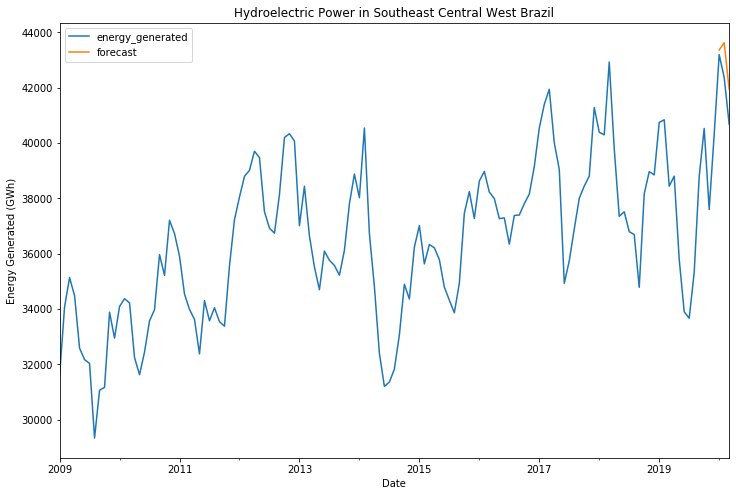

In [15]:
# Plotting results of SARIMA

pred_length = 6

df_new = df.copy()
df_new.set_index('date', inplace = True)
df_new = df_new[(df_new.index >= pd.to_datetime('2009-01-01',format = '%Y-%m-%d')) & (df_new.index <= pd.to_datetime('2020-03-01',format = '%Y-%m-%d'))]


nrg_gen = df_new['energy_generated'][:-pred_length]

model=sm.tsa.statespace.SARIMAX(nrg_gen, order=(p, d, q),seasonal_order=(P,D,Q,m))
results=model.fit()
df_new['forecast']=results.predict(start=pd.to_datetime('2020-01-01',format = '%Y-%m-%d'),end=pd.to_datetime('2020-03-01',format = '%Y-%m-%d'),dynamic=False)


df_new[['energy_generated','forecast']].plot(figsize=(12,8))

#plotting energy generated over full time period
# plt.plot(df_new.date[:], df_new.energy_generated[:], '-b', label = 'Energy Generated')   
# # plt.plot(x, y1, "-b", label="fish")

# plt.plot(df_new.date[:], df_new.forecast[:], '-r')
plt.title('Hydroelectric Power in Southeast Central West Brazil')
# Units not in GWh
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');

plt.savefig('foo.png')


plt.show()

In [14]:
# cross validation of SARIMA on limited time window

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df_new['energy_generated'].copy()

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # SARIMA
    # Parameters basically random at this point
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(1, 1, 1),seasonal_order=(0,1,2,12)).fit()
    fit =sm.tsa.statespace.SARIMAX(endog=y_train, order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(0, 0,1),seasonal_order=(2,0,1,m)).fit()
    fcast = fit.forecast(pred_length)
#     fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
#     fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of SARIMA is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))


We are predicting 3 months in advance
[1897.3464096488995, 550.7420611319321, 1741.540279867312, 1642.5413071080038, 2623.7025155766582, 2054.018040787829, 1909.8837939210232, 1547.8313927885247, 2805.9851614082545, 1940.6641140786476, 515.2396611897979]
The CV MAE of SARIMA is 1748.1358852278986
That is 0.047875541411350885 percent of the mean power output


In [76]:
df_new[(df_new.index >= pd.to_datetime('2009-01-01',format = '%Y-%m-%d')) & (df_new.index <= pd.to_datetime('2020-03-01',format = '%Y-%m-%d'))]

,energy_generated,forecast
date,,
2009-01-01,31586.57332,NaN
2009-02-01,34074.67384,NaN
2009-03-01,35134.24204,NaN
2009-04-01,34482.11683,NaN
2009-05-01,32584.10723,NaN
...,...,...
2019-11-01,37601.67158,NaN
2019-12-01,40307.36475,NaN
2020-01-01,43196.68314,NaN


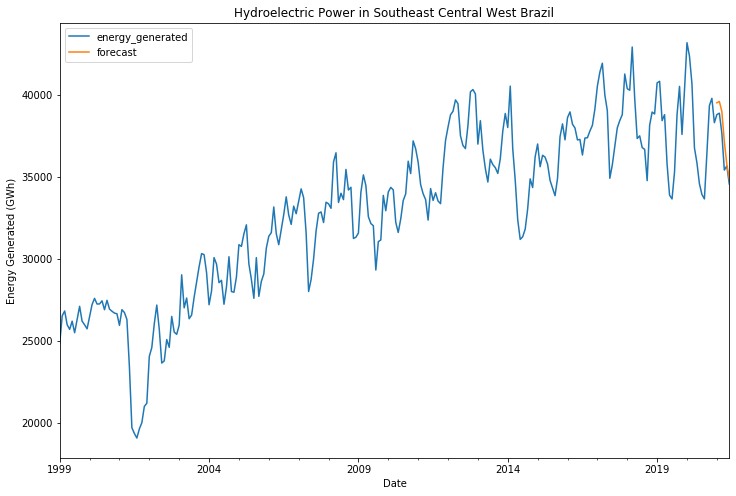

In [11]:
# Plotting results of SARIMA

pred_length = 6

df_new = df.copy()


nrg_gen = df_new['energy_generated'][:-pred_length]

model=sm.tsa.statespace.SARIMAX(nrg_gen, order=(p, d, q),seasonal_order=(P,D,Q,m))
results=model.fit()
df_new['forecast']=results.predict(start=(len(df)-pred_length),end=(len(df)-1),dynamic=False)

df_new.set_index('date', inplace = True)

df_new[['energy_generated','forecast']].plot(figsize=(12,8))

#plotting energy generated over full time period
# plt.plot(df_new.date[:], df_new.energy_generated[:], '-b', label = 'Energy Generated')   
# # plt.plot(x, y1, "-b", label="fish")

# plt.plot(df_new.date[:], df_new.forecast[:], '-r')
plt.title('Hydroelectric Power in Southeast Central West Brazil')
# Units not in GWh
plt.ylabel('Energy Generated (GWh)');
plt.xlabel('Date');

plt.savefig('foo.png')


plt.show()

Now that we have a pretty good SARIMA model working, let's see if we can get exogenous variables added

In [45]:
df2 = df.copy()

# df2['rain'] = range(0,len(df2))



df_rain = pd.read_csv("./monthly_rain_timeseries.csv")

# df_rain.tail()

df_rain['date'] = pd.to_datetime(df_rain['date'],format = '%Y-%m-%d')  

df2 = df2.merge(df_rain, how = 'inner', on = 'date')

print(df2)
# # check for missing dates... seems there are none
# print(pd.date_range(
#   start="2007-01-01", end="2020-12-01", freq = 'MS').difference(df_rain['date']))

# print(df_rain)

          date  energy_generated  Unnamed: 0   rain_mm
0   2007-01-01       33539.40173           1  9.150830
1   2007-02-01       34280.22374           2  5.145982
2   2007-03-01       33739.08584           3  2.606689
3   2007-04-01       31580.06961           4  2.206373
4   2007-05-01       28019.47681           5  1.524306
..         ...               ...         ...       ...
163 2020-08-01       33668.01884         164  1.622278
164 2020-09-01       36442.88578         165  0.559081
165 2020-10-01       39355.75458         166  2.308372
166 2020-11-01       39803.98729         167  2.904365
167 2020-12-01       38317.98973         168  4.931423

[168 rows x 4 columns]


In [46]:
# cross validation of SARIMA with exog

# size of prediction window
pred_length = 3
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df2['energy_generated'].copy()
rainfall = df2['rain_mm'].copy()

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    x_train, x_test = rainfall[train_index], rainfall[test_index]
    # SARIMA
    # Parameters basically random at this point
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(1, 1, 1),seasonal_order=(0,1,2,12)).fit()
    fit =sm.tsa.statespace.SARIMAX(endog=y_train, exog=x_train, order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(0, 0,1),seasonal_order=(2,0,1,m)).fit()
    fcast = fit.forecast(pred_length, exog = x_test)
#     fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
#     fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of SARIMA is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))


We are predicting 3 months in advance
[1708.9667441971299, 2698.1897287734682, 2331.00027581468, 1807.0516769317499, 1229.0160740337499, 2385.606594622043, 1501.5036216228182, 871.987919477222, 2642.9906975346166, 1241.119407886644, 1580.550339032503]
The CV MAE of SARIMA is 1817.9984618115113
That is 0.050501708968322866 percent of the mean power output


In [7]:
# cross validation of SARIMA

# size of prediction window
pred_length = 6
# tell us how many days we are predicting
print('We are predicting %s months in advance' %pred_length)
# number of cross-validtion splits to do
cross_splits = 11
# setting up the indexing of the cross validation
tscv = TimeSeriesSplit(n_splits=cross_splits, test_size = pred_length)
# setting aside energy_generated
nrg_gen = df2['energy_generated'].copy()
rainfall = df2['rain_mm'].copy()

# initializing list to store MAEs
mae_list = [0]*cross_splits
# counter to put in list
n = 0

# for loop so that we can test over all of our cross validation splits
for train_index, test_index in tscv.split(nrg_gen):
    y_train, y_test = nrg_gen[train_index], nrg_gen[test_index]
    # SARIMA
    # Parameters basically random at this point
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(1, 1, 1),seasonal_order=(0,1,2,12)).fit()
    fit =sm.tsa.statespace.SARIMAX(endog=y_train, order=(p, d,q),seasonal_order=(P,D,Q,m)).fit()
#     fit =sm.tsa.statespace.SARIMAX(y_test, order=(0, 0,1),seasonal_order=(2,0,1,m)).fit()
    fcast = fit.forecast(pred_length)
#     fit = ExponentialSmoothing(y_train, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
#     fcast = fit.forecast(pred_length).rename("Holt-Winter multiplicative")
    # printing parameters and MAE
    mae = mean_absolute_error(fcast,y_test)
    mae_list[n] = mae
    n += 1
    
print(mae_list)
print('The CV MAE of SARIMA is %s' %np.mean(mae_list))
print('That is %s percent of the mean power output' %(np.mean(mae_list)/np.mean(nrg_gen)))


We are predicting 6 months in advance


NameError: name 'df2' is not defined

In [47]:
print(nrg_gen)
print(rainfall)

0      33539.40173
1      34280.22374
2      33739.08584
3      31580.06961
4      28019.47681
          ...     
163    33668.01884
164    36442.88578
165    39355.75458
166    39803.98729
167    38317.98973
Name: energy_generated, Length: 168, dtype: float64
0      9.150830
1      5.145982
2      2.606689
3      2.206373
4      1.524306
         ...   
163    1.622278
164    0.559081
165    2.308372
166    2.904365
167    4.931423
Name: rain_mm, Length: 168, dtype: float64
